# 01 Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%config InlineBackend.figure_format='retina'


In [2]:
# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)
%matplotlib inline

# 02 Import data 

In [3]:
path = r'/Users/woodoooo/Desktop/World University Rankings'

In [6]:
file = os.path.join(path, '02_Data', 'Prepared Data', 'X_imputed_score_and_clusters.xlsx')

In [7]:
df = pd.read_excel(file)

In [8]:
df.head()

,AR SCORE,ER SCORE,FSR SCORE,CPF SCORE,IFR SCORE,ISR SCORE,ISD SCORE,IRN SCORE,EO SCORE,SUS SCORE,clusters,cluster
0,100.0,100.0,100.0,100.0,100.0,91.6,92.3,94.1,100.0,93.8,0,cluster_0
1,99.6,100.0,99.3,95.0,100.0,100.0,100.0,97.5,95.9,98.3,0,cluster_0
2,100.0,100.0,100.0,99.7,94.2,73.5,76.1,96.5,100.0,95.4,0,cluster_0
3,100.0,100.0,100.0,91.0,98.8,98.6,98.7,100.0,100.0,77.9,0,cluster_0
4,100.0,100.0,98.3,100.0,79.1,81.4,60.6,99.4,100.0,77.8,0,cluster_0


In [10]:
df = df.drop('cluster', axis = 1)

In [13]:
df.shape

(701, 11)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AR SCORE   701 non-null    float64
 1   ER SCORE   701 non-null    float64
 2   FSR SCORE  701 non-null    float64
 3   CPF SCORE  701 non-null    float64
 4   IFR SCORE  701 non-null    float64
 5   ISR SCORE  701 non-null    float64
 6   ISD SCORE  701 non-null    float64
 7   IRN SCORE  701 non-null    float64
 8   EO SCORE   701 non-null    float64
 9   SUS SCORE  701 non-null    float64
 10  clusters   701 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 60.4 KB


## Step 1: Reduce Dimensionality

## In this step, we will find the optimal number of components which capture the greatest amount of variance in the data. 

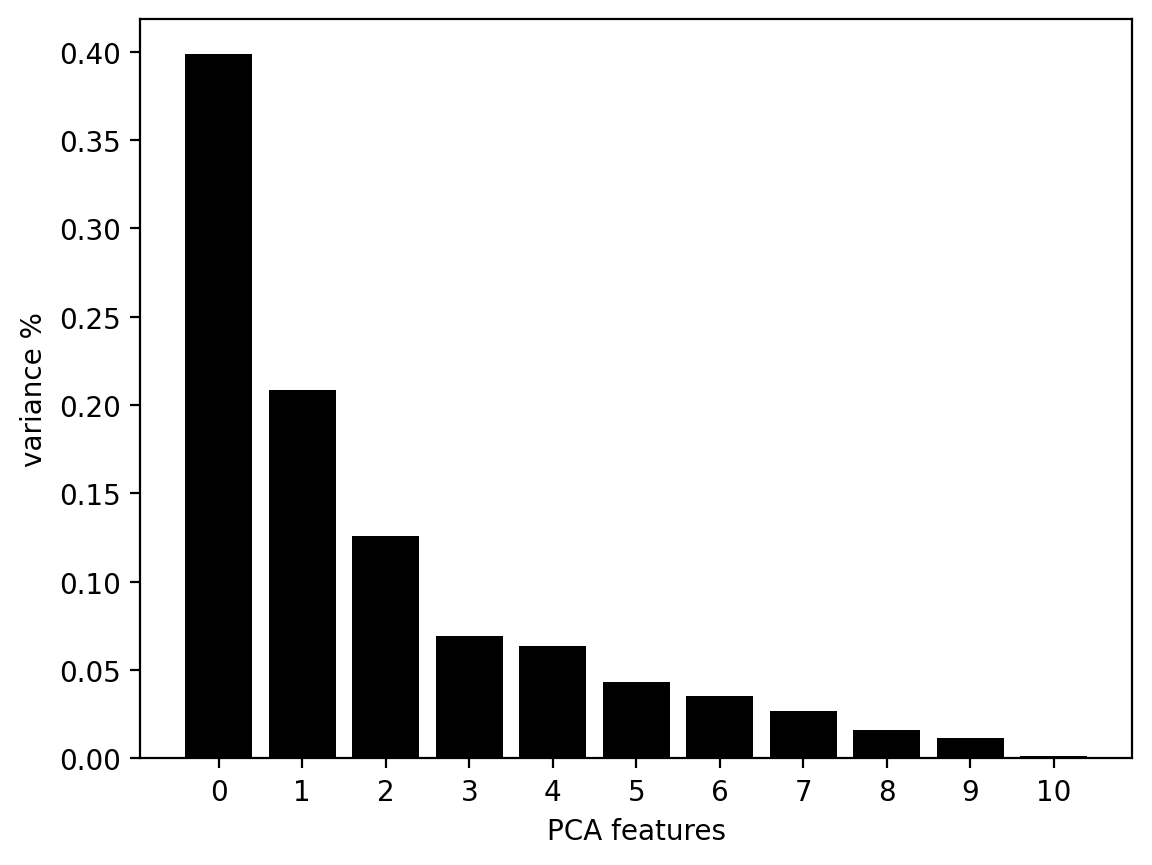

In [19]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)

# Create a PCA instance: pca
pca = PCA(n_components=11)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

In [20]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [30]:
# Plot below shows that the first 2 components explain the majority of the variance in our data. 
# For this visualization use case, we will quickly plot just the first two. 
# We do this to notice if there are any clear clusters.

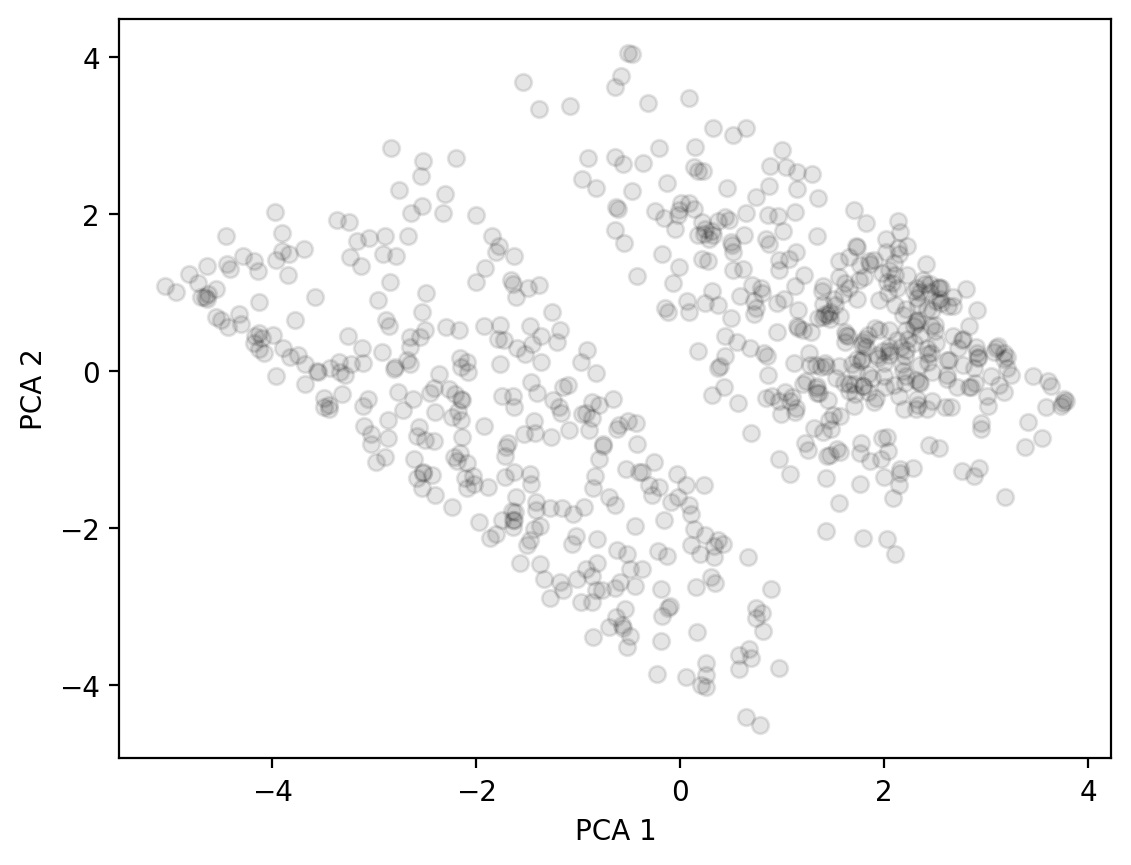

In [26]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## Step 2: Find the Clusters

## In this step, we will use k-means clustering to view the top three PCA components. 

To do this, we will first fit these principal components to the k-means algorithm and determine the best number of clusters. Determining the ideal number of clusters for our k-means model can be done by measuring the sum of the squared distances to the nearest cluster center aka inertia. Much like the scree plot in fig. 1 for PCA, the k-means scree plot below indicates the percentage of variance explained, but in slightly different terms, as a function of the number of clusters.

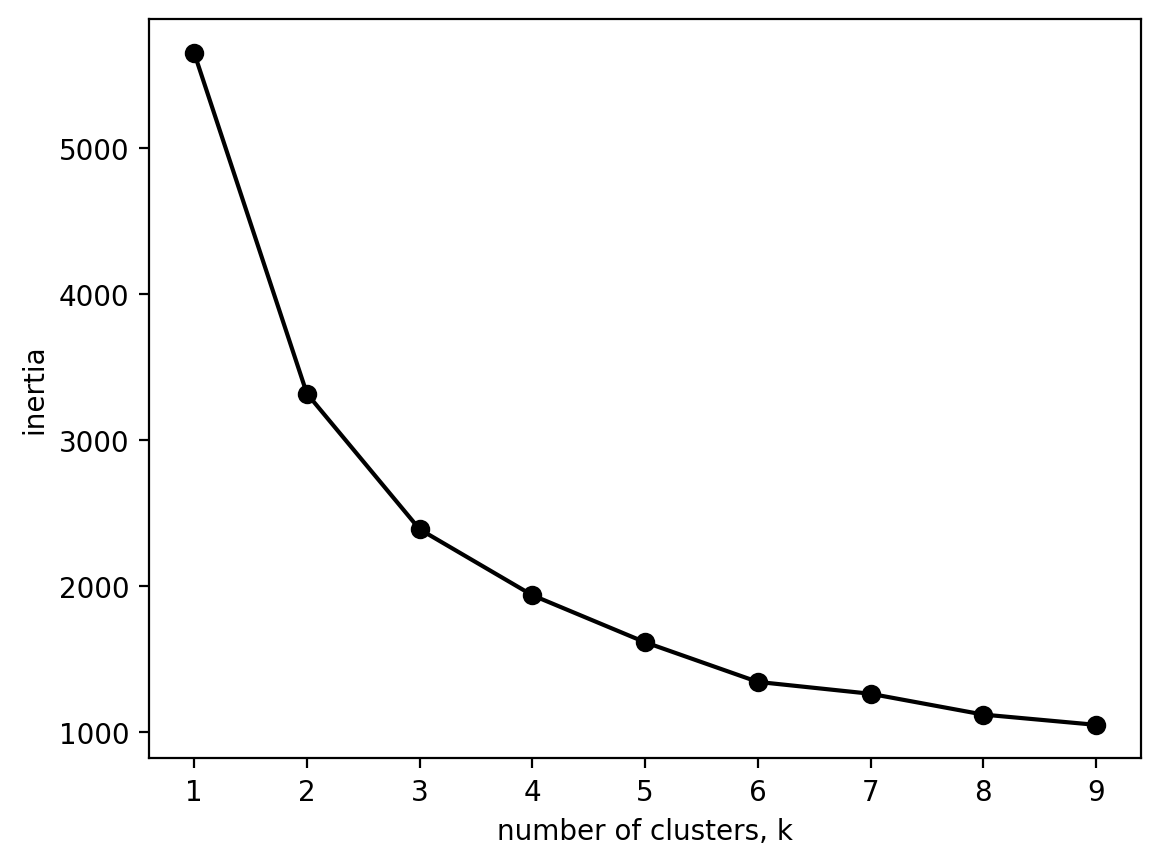

In [31]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [33]:
# Plot above shows that after 2 clusters(at the elbow), the change in the value of inertia is no longer significant, 
# and most likely, neither is the variance of the rest of the data after the elbow point. 
# Therefore we can discard everything after k=4 and proceed to the last step in the process.

## Step 3: Visualize and Interpret the Clusters

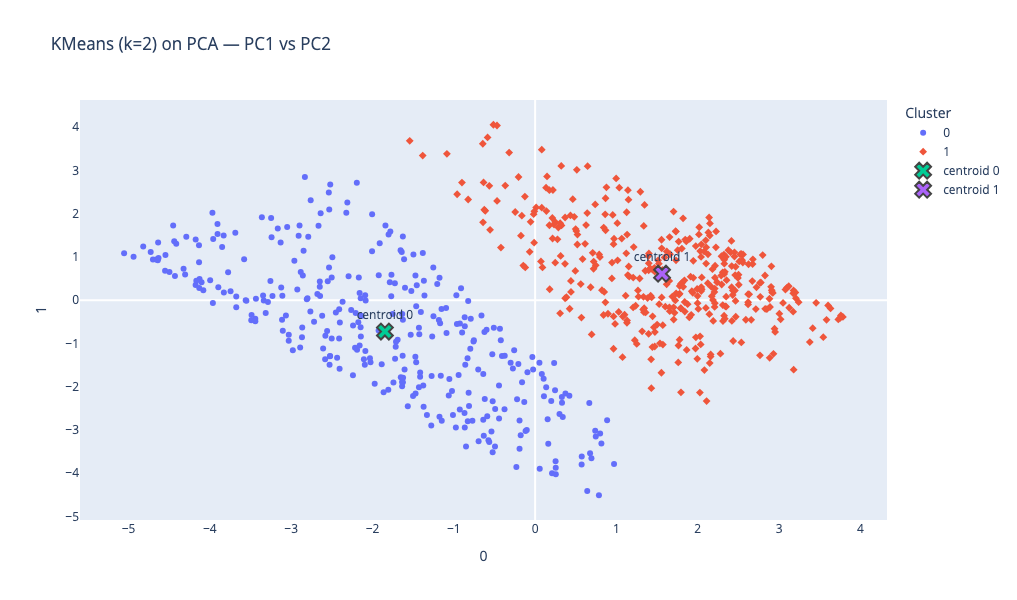

In [45]:
# Plotly visualization of 2 clusters (or any k) on PCA components
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans

# --------- Parameters (изменяй по необходимости) ----------
K = 2
pc_cols = PCA_components.columns[:3]  
pc1, pc2, pc3 = pc_cols[0], pc_cols[1], pc_cols[2]
# ----------------------------------------------------------

# Run KMeans and attach labels
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(PCA_components[[pc1, pc2, pc3]])
PCA_components['cluster'] = labels.astype(str)   

# Prepare centroid coordinates in PC space
centroids = kmeans.cluster_centers_  # shape (K, 3)

# ------------ 2D Plot (PC1 vs PC2) with centroids -------------
fig2 = px.scatter(
    PCA_components,
    x=pc1, y=pc2,
    color='cluster',
    symbol='cluster',
    title=f'KMeans (k={K}) on PCA — PC1 vs PC2',
    hover_data=PCA_components.columns.tolist(),  
    width=800, height=600
)

# add centroid markers (bigger, cross)
for i, c in enumerate(centroids):
    fig2.add_trace(
        go.Scatter(
            x=[c[0]], y=[c[1]],
            mode='markers+text',
            marker=dict(symbol='x', size=14, line=dict(width=2)),
            text=[f'centroid {i}'],
            textposition='top center',
            name=f'centroid {i}',
            showlegend=True
        )
    )

fig2.update_layout(legend_title_text='Cluster')

# Remove grid lines
fig2.update_xaxes(showgrid=False)
fig2.update_yaxes(showgrid=False)

# Save figure as PNG
output_path = os.path.join(path, '04 Analysis', 'Visualisation', "Clusters with centroids.png")
fig2.write_image(output_path, scale=3)  


fig2.show()

In [ ]:
в